# 데이터 마이닝 기말 프로젝트
> 20185280 이주원

# Import Module

In [0]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

# Load Dataset

In [23]:
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
# 데이타셋 출처 : https://github.com/datasets/covid-19/tree/master/data
# url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
url = 'https://raw.githubusercontent.com/juwonlee-dev/covid-19/master/data/time-series-19-covid-combined.csv' # 2020-06-07 까지
data = pd.read_csv(url, error_bad_lines = False)

data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


# Extract Korea Data

In [24]:
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South'] # 한국 데이터만 추출

df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed])
df_korea = pd.DataFrame(df_korea)

df_korea = df_korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_korea = df_korea.drop("index", axis=1)

# 2020-06-08 기준
# 8일자 데이터가 갱신되지 않아 직접 데이터를 추가해줍니다.
df_korea = df_korea.append([
   {'date': pd.to_datetime('2020-06-08'), 'confirmed': 11814},
   {'date': pd.to_datetime('2020-06-09'), 'confirmed': 11852},
   {'date': pd.to_datetime('2020-06-10'), 'confirmed': 11902}
], ignore_index=True)

df_korea.tail()
#df_korea.head()

,date,confirmed
136,2020-06-06,11719
137,2020-06-07,11776
138,2020-06-08 00:00:00,11814
139,2020-06-09 00:00:00,11852
140,2020-06-10 00:00:00,11902


In [25]:
df_japan = data[data['Country/Region'] == 'Japan'] # 일본 데이터만 추출

df_japan = np.column_stack([df_japan.Date, df_japan.Confirmed])
df_japan = pd.DataFrame(df_japan)

df_japan = df_japan.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_japan = df_japan.drop("index", axis=1)

df_japan.tail()

,date,confirmed
132,2020-06-02,16837
133,2020-06-03,16867
134,2020-06-04,16911
135,2020-06-05,16958
136,2020-06-06,17000


In [26]:
df_newZealand = data[data['Country/Region'] == 'New Zealand'] # 뉴질랜드 데이터만 추출

df_newZealand = np.column_stack([df_newZealand.Date, df_newZealand.Confirmed])
df_newZealand = pd.DataFrame(df_newZealand)

df_newZealand = df_newZealand.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_newZealand = df_newZealand.drop("index", axis=1)

df_newZealand.tail()

,date,confirmed
132,2020-06-02,1504
133,2020-06-03,1504
134,2020-06-04,1504
135,2020-06-05,1504
136,2020-06-06,1504


# Plot Graph

In [27]:
# 한국 코로나19 확진자 트렌드를 그래프로 시각화합니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = df_korea.date,
        y = df_korea.confirmed,
        name = 'Confirmed in Korea'
    )
)

fig

In [28]:
fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(
        x = df_japan.date,
        y = df_japan.confirmed,
        name = 'Confirmed in Japan'
    )
)

fig2

In [29]:
fig3 = go.Figure()

fig3.add_trace(
    go.Scatter(
        x = df_newZealand.date,
        y = df_newZealand.confirmed,
        name = 'Confirmed in New Zealand'
    )
)

fig3

# Facebook Prophet

In [30]:
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
136,2020-06-06,11719
137,2020-06-07,11776
138,2020-06-08 00:00:00,11814
139,2020-06-09 00:00:00,11852
140,2020-06-10 00:00:00,11902


# Model Create

In [31]:
# Prophet 모델을 만듭니다
model = Prophet( # 자세한 내부 알고리즘은 비공개이지만 Linear Model입니다.
    changepoint_prior_scale=0.2, # 값이 커질수록 모델을 더 유연하게 바꿉니다.
    changepoint_range=0.9, # 데이터 앞부분의 몇 퍼센트 부분안에서 변곡점을 만들지에 대한 설정입니다.
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

model.fit(df_prophet)

future = model.make_future_dataframe(periods=7) # 향후 7일간의 확진자 수를 예측합니다.
forecast = model.predict(future) # 예측

# 날짜, 예측값, 예측값 최소, 최대
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)) # 예측한 7일의 데이터를 출력합니다. 2020-06-11~2020-06-17
print()

# 시각화
fig = plot_plotly(model, forecast)
py.iplot(fig)

            ds          yhat    yhat_lower    yhat_upper
141 2020-06-11  11943.099902  11894.890970  11990.227261
142 2020-06-12  11987.017885  11924.380928  12044.227694
143 2020-06-13  12030.935867  11952.014884  12106.875338
144 2020-06-14  12074.853850  11934.127353  12205.157612
145 2020-06-15  12118.771833  11910.824933  12309.758644
146 2020-06-16  12162.689816  11880.456954  12427.947350
147 2020-06-17  12206.607799  11833.957949  12529.917548



# Plot changepoints

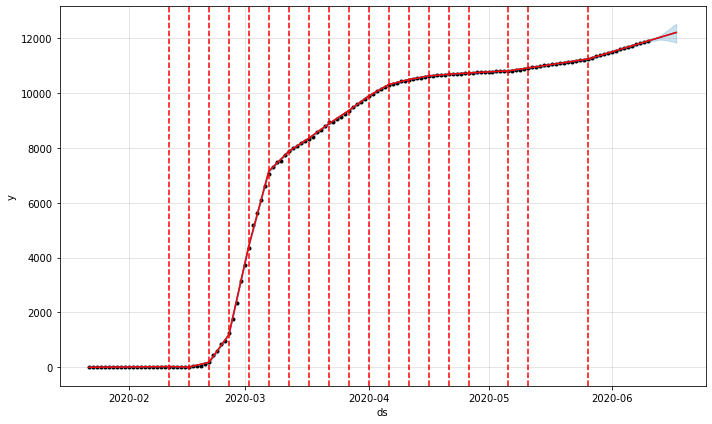

In [32]:
# changepoint를 그래프에 반영해봅시다.
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)